# Setup

In [1]:
%pip install imageio
%pip install pyvirtualdisplay
%pip install tf-agents
%pip install pyglet
%pip install matplotlib
%pip install tensorflow


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you 

In [2]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

# Seed for PPO actor network
import tensorflow_probability as tfp

# PPO Agent
from tf_agents.agents.ppo import ppo_agent
from tf_agents.agents.ppo import ppo_clip_agent
from tf_agents.agents.ppo import ppo_actor_network
from tf_agents.networks import value_network
from tf_agents.networks import actor_distribution_network
from tf_agents.agents.ppo import ppo_clip_agent

from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

from tf_agents.networks import sequential

# old agent
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network


from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

# Set up a virtual display for rendering OpenAI gym environments.
# display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

2023-03-06 21:49:34.020715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Hyperparameters

In [3]:

env_name = "CartPole-v1"
env_name = "Acrobot-v1"
batch_size = 64  # @param {type:"integer"}


# Environment

In [4]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

observation_tensor_spec = tensor_spec.from_spec(train_env.observation_spec())
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
time_step_tensor_spec = tensor_spec.from_spec(train_env.time_step_spec())

In [5]:
print('Observation: {0}'.format(observation_tensor_spec))
print('Action: {0}'.format(action_tensor_spec))
print('TimeStep: {0}'.format(time_step_tensor_spec))

Observation: BoundedTensorSpec(shape=(6,), dtype=tf.float32, name='observation', minimum=array([ -1.      ,  -1.      ,  -1.      ,  -1.      , -12.566371,
       -28.274334], dtype=float32), maximum=array([ 1.      ,  1.      ,  1.      ,  1.      , 12.566371, 28.274334],
      dtype=float32))
Action: BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(2))
TimeStep: TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(6,), dtype=tf.float32, name='observation', minimum=array([ -1.      ,  -1.      ,  -1.      ,  -1.      , -12.566371,
       -28.274334], dtype=float32), maximum=array([ 1.      ,  1.      ,  1.      ,  1.      , 12.566371, 28.274334],
      dtype=float32)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

# Agent

Netowork

In [6]:
# actor_net_builder = ppo_actor_network.PPOActorNetwork()
# actor_net = actor_net_builder.create_sequential_actor_net(
#     actor_fc_layers, action_tensor_spec)


actor_fc_layers = (64,64)
value_fc_layers = (64,64)


actor_net = actor_distribution_network.ActorDistributionNetwork(
        observation_tensor_spec,
        action_tensor_spec,
        fc_layer_params=actor_fc_layers,
        activation_fn=tf.nn.tanh,
        kernel_initializer=tf.keras.initializers.Orthogonal(seed=1),
        seed_stream_class=tfp.util.SeedStream(seed=None, salt='tf_agents_sequential_layers')
)

value_net = value_network.ValueNetwork(
    observation_tensor_spec,
    fc_layer_params=value_fc_layers,
    activation_fn=tf.keras.activations.tanh,
    kernel_initializer=tf.keras.initializers.Orthogonal()
)

Optimizer

In [7]:
print(observation_tensor_spec)
print(action_tensor_spec)
print(time_step_tensor_spec)

BoundedTensorSpec(shape=(6,), dtype=tf.float32, name='observation', minimum=array([ -1.      ,  -1.      ,  -1.      ,  -1.      , -12.566371,
       -28.274334], dtype=float32), maximum=array([ 1.      ,  1.      ,  1.      ,  1.      , 12.566371, 28.274334],
      dtype=float32))
BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(2))
TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(6,), dtype=tf.float32, name='observation', minimum=array([ -1.      ,  -1.      ,  -1.      ,  -1.      , -12.566371,
       -28.274334], dtype=float32), maximum=array([ 1.      ,  1.      ,  1.      ,  1.      , 12.566371, 28.274334],
      dtype=float32)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


In [8]:
# epsilon = 0.2
epsilon = 0.2
discount = 0.99
lambda_value = 0.95
train_step_counter = tf.Variable(0)


# learning_rate = 3e-4
learning_rate = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

initial_learning_rate = 10e-3
decay_steps = 1000
decay_rate = 0.96

# global_step = tf.Variable(0, trainable=False) Uset the same trin_step_counter
learning_rate = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=True
)



agent_ppo = ppo_clip_agent.PPOClipAgent(
    time_step_spec=time_step_tensor_spec,
    action_spec=action_tensor_spec,
    optimizer=optimizer,
    actor_net=actor_net,
    value_net=value_net,
    greedy_eval=False,
    lambda_value=lambda_value,
    discount_factor=discount,
    importance_ratio_clipping=epsilon,
    num_epochs=25,
    normalize_observations=True,
    normalize_rewards=True,
    use_gae=True,
    # log_prob_clipping=epsilon,
    # gradient_clipping=epsilon,
    # value_clipping=epsilon,
    train_step_counter=train_step_counter,
)
agent_ppo.initialize()


2023-03-06 21:49:38.274238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/ribeirg/Documents/pessoal/tg/git/learning-tg-agents/venvIntelliJ/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


# Metrics and Evaluation

In [9]:
train_env.current_time_step()

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 0.99998146, -0.00609106,  0.9990883 ,  0.04269192, -0.00122559,
         0.0051249 ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})

In [10]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

random_policy = random_tf_policy.RandomTFPolicy(
    time_step_tensor_spec,
    action_tensor_spec,
    info_spec=time_step_tensor_spec)

num_eval_episodes=1
def evaluate_policy(policy):
  for _ in range(1):
    avg= compute_avg_return(eval_env, policy, num_eval_episodes)
    print(avg)

# evaluate_policy(random_policy)

# evaluate_policy(agent_ppo.policy)

evaluate_policy(agent_ppo.collect_policy)


-500.0


# Data Collection

In [15]:
agent_ppo.collect_policy.trajectory_spec

_TupleWrapper(Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(2)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(6,), dtype=tf.float32, name='observation', minimum=array([ -1.      ,  -1.      ,  -1.      ,  -1.      , -12.566371,
       -28.274334], dtype=float32), maximum=array([ 1.      ,  1.      ,  1.      ,  1.      , 12.566371, 28.274334],
      dtype=float32)),
 'policy_info': {'dist_params': {'logits': TensorSpec(shape=(3,), dtype=tf.float32, name='CategoricalProjectionNetwork_logits')}},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')}))

In [11]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent_ppo.collect_policy.trajectory_spec,
    batch_size=1,
    max_length=10000)
    # max_length=10000)


def collect_step(environment, policy):
    time_step = environment.current_time_step()
    print(time_step)
    action_step = policy.action(time_step)
    print(action_step)
    next_time_step = environment.step(action_step.action)
    print(next_time_step)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    print(traj)
    # print(next_time_step.reward)

initial_collect_steps=10
for _ in range(initial_collect_steps):
    collect_step(train_env, agent_ppo.collect_policy)

# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
n_step_update=1
initial_collect_steps=10
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(batch_size)

iterator = iter(dataset)

# print(f'TimeStep: {train_env.time_step_spec()}')
# print(f'Action: {train_env.action_spec()}')
# print(f'Agent: {agent_ppo.collect_policy.time_step_spec}')

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 0.99998146, -0.00609106,  0.9990883 ,  0.04269192, -0.00122559,
         0.0051249 ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>, state=(), info={'dist_params': {'logits': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.35860622, 0.00586434, 0.06976362]], dtype=float32)>}})
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 0.9998371 , -0.01804963,  0.99733675,  0.07293405, -0.11480132,
         0.29035622]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy

# Training the Agent

In [12]:
try:
  %%time
except:
  pass

num_iterations = 10000
collect_steps_per_iteration = 1
eval_interval = 10
num_eval_episodes = 1


# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent_ppo.train = common.function(agent_ppo.train)

# Reset the train step
agent_ppo.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent_ppo.collect_policy, num_eval_episodes)
returns = [avg_return]
returns
# 
# for _ in range(num_iterations):
#   # Collect a few steps using collect_policy and save to the replay buffer.
#   for _ in range(collect_steps_per_iteration):
#     collect_step(train_env, agent_ppo.collect_policy)
#   # Sample a batch of data from the buffer and update the agent's network.
#   experience, unused_info = next(iterator)
#   train_loss = agent_ppo.train(experience).loss
#   # experience, unused_info = next(iterator)
#   # train_loss = agent_ppo.train(experience).loss
# 
#   step = agent_ppo.train_step_counter.numpy()
# 
#   if step % eval_interval == 0:
#     avg_return = compute_avg_return(eval_env, agent_ppo.policy, num_eval_episodes)
#     print('step = {0}: loss = {1}  AVG RETURN: {2:2f}'.format(step, train_loss, avg_return))
# 
#   returns.append(avg_return)

new_epsilon = epsilon
for _ in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent_ppo.collect_policy)
    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent_ppo.train(experience).loss
    # experience, unused_info = next(iterator)
    # train_loss = agent_ppo.train(experience).loss
    if not (train_step_counter.value() % 1020):
        new_epsilon = new_epsilon - 0.01
        if new_epsilon < 0.01:
            new_epsilon = 0.01
        agent_ppo._importance_ratio_clipping = new_epsilon
        print('**** new_epsilon = {0} ***'.format(new_epsilon))


    step = agent_ppo.train_step_counter.numpy()

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent_ppo.policy, num_eval_episodes)
        print('step = {0}: loss = {1}  AVG RETURN: {2:2f}  Epsilon: {3}'.format(step, train_loss, avg_return, agent_ppo._importance_ratio_clipping))
        returns.append(avg_return)


TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 0.9997651 , -0.02167282,  0.98731726,  0.15875952,  0.19313438,
        -0.44814312]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>})
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info={'dist_params': {'logits': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.11474635, -0.10717109,  0.15675601]], dtype=float32)>}})
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 0.9994349 ,  0.03361329,  0.9997695 ,  0.02146881,  0.34426832,
        -0.89915526]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, n

KeyboardInterrupt: 

# Visualization

In [96]:
len(returns)

5001

ValueError: x and y must have same first dimension, but have shapes (10001,) and (5001,)

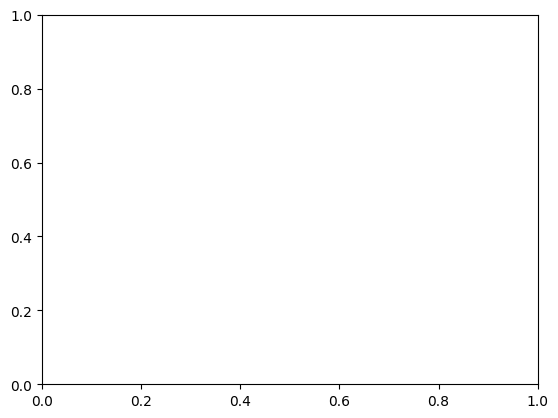

In [98]:
steps = range(0, num_iterations + 1, 1)
# steps = range(0, num_iterations + 1, 10)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=max(returns) + 10)